In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from IPython.display import HTML

HTML('''
<script>
    code_show = false; // Hide code by default

    function code_toggle() {
        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show;
    }

    $(document).ready(function(){
        $('div.input').hide(); // Hides code at load
    });
</script>

<form action="javascript:code_toggle()">
    <input type="submit" value="Toggle Code">
</form>
''')


## RibonanzaNet-SM_004

Same sequences used for train/val/test split as 002 and 003.

Finetuning RibonanzaNet on just the reactivity *differences* of all conditions at once (NOT including NoDr baseline) results
* From training on 2094 sequences, split training data into training and validation data.
* criterion: MAE
* epochs: 20
* train_snr_cutoff: 1
* val_snr_cutoff: 1
* training_script: SM_train_reac_diff_only.py
* training data: rdiff_train.json
* validation data: rdiff_val.json
* test data: rdiff_test.json
* model saved as: RibonanzaNet-SM_004.pt
* sbatch script: sm_train_all_reac_diff_simultaneously.sbatch.sh
* Sherlock Job #: **56196107**

In [21]:
df = pd.read_json('RibonanzaNet-SM_004_test_data_with_rdiff_preds.json')

### Computing PCC with experimental and predicted reactivity vectors, per condition: 

In [22]:
import ast
import numpy as np
import pandas as pd

# Define condition columns
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']
prediction_conditions = [col + '_pred_rdiff' for col in conditions]

# Create a new DataFrame to hold results
comparison_results = {}

for col in conditions:
    pcc_list = []
    for exp_raw, pred_raw in zip(df[col], df[col + '_pred_rdiff']):
        try:
            exp_vals = np.array(ast.literal_eval(str(exp_raw)))
            pred_vals = np.array(ast.literal_eval(str(pred_raw)))

            if len(exp_vals) == len(pred_vals) and len(exp_vals) > 1:
                pcc = np.corrcoef(exp_vals, pred_vals)[0, 1]
            else:
                pcc = None
        except Exception:
            pcc = None

        pcc_list.append(pcc)

    comparison_results[col] = pcc_list

# Create DataFrame with PCCs
comparison_df = pd.DataFrame(comparison_results)

# Display all individual PCCs
print(comparison_df)

# Compute average PCC per condition
average_pcc = comparison_df.mean()
print("\nAverage PCC per condition:")
print(average_pcc)


         Argi      Eryt      Kana      Mito      Paro      Spec      Tetr
0    0.241976  0.440998  0.697820  0.702475  0.740247  0.127836  0.883271
1    0.045279 -0.055498 -0.018635  0.629411  0.394035 -0.296934  0.439313
2    0.474509  0.186753  0.719004  0.888588  0.395240  0.141692  0.774813
3    0.130765  0.128042  0.556191  0.730712  0.640578  0.321024  0.608420
4    0.125253  0.313285  0.484074  0.910592  0.826864  0.109111  0.867474
..        ...       ...       ...       ...       ...       ...       ...
541  0.358850  0.312289  0.346687  0.266036  0.352849  0.196082  0.560357
542  0.243779  0.111621  0.430747  0.772932  0.636660 -0.042648  0.559376
543 -0.230341  0.054109  0.242765  0.894968  0.583234 -0.055290  0.798499
544 -0.027033 -0.005661  0.144327  0.842180  0.377229  0.056673  0.578233
545  0.240456  0.279315  0.303715  0.684834  0.669601  0.218349  0.772716

[546 rows x 7 columns]

Average PCC per condition:
Argi    0.186831
Eryt    0.226244
Kana    0.315012
Mito    0

### Computing PCC between a sliding window sum of nucleotides with significant reactivity differences: 

Significance is defined as beign in the top 20% of reactivity differences after normalization. 

In [23]:
# Flag top 20% of reactivity differences and then do a sliding window sum and compute PCC

import ast
# Columns to process (excluding '_SN' columns)
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']
prediction_conditions = [col + '_pred_rdiff' for col in conditions]

# Create a new DataFrame to store flagged vectors
flagged_df = df[['id', 'sequence']].copy()

# Function to normalize and flag top 80%
def normalize_and_flag(reactivity_list):
    reactivity_array = np.array(reactivity_list)
    min_val, max_val = np.min(reactivity_array), np.max(reactivity_array)
    normalized = (reactivity_array - min_val) / (max_val - min_val) if max_val > min_val else reactivity_array
    threshold = np.percentile(normalized, 80)
    return [1 if val >= threshold else 0 for val in normalized]

# Function to compute sliding window sums
def sliding_window_sum(flagged_list, window_size=5):
    return [sum(flagged_list[i:i+window_size]) for i in range(len(flagged_list) - window_size + 1)]

# Process each condition and prediction condition
for col in conditions + prediction_conditions:
    flagged_df[col] = df[col].apply(lambda x: normalize_and_flag(ast.literal_eval(str(x))))

# Compute sliding window sums
for col in conditions + prediction_conditions:
    flagged_df[col + '_window_sum'] = flagged_df[col].apply(lambda x: sliding_window_sum(x))

# Compare actual to predicted
comparison_results = {}
for col in conditions:
    actual_sums = flagged_df[col + '_window_sum']
    predicted_sums = flagged_df[col + '_pred_rdiff_window_sum']
    comparison_results[col] = [np.corrcoef(actual, predicted)[0, 1] if len(actual) == len(predicted) else None
                               for actual, predicted in zip(actual_sums, predicted_sums)]

comparison_df = pd.DataFrame(comparison_results)

print(comparison_df)

# Compute and print average PCC for each condition
average_pcc = comparison_df.mean()
print("\nAverage PCC per condition:")
print(average_pcc)



         Argi      Eryt      Kana      Mito      Paro      Spec      Tetr
0    0.143016  0.664237  0.441511  0.781947  0.551075 -0.225523  0.840859
1    0.469506  0.063077 -0.271296  0.283851  0.177415 -0.251597  0.320540
2    0.482032  0.243509  0.656354  0.882677 -0.251306  0.241954  0.400993
3    0.631638  0.188933  0.420401  0.254172  0.715646  0.734615  0.640180
4    0.215494 -0.316545  0.382236  0.818577  0.689605  0.368225  0.788854
..        ...       ...       ...       ...       ...       ...       ...
541  0.097118  0.160882  0.264378  0.433932  0.184982  0.289146  0.651356
542 -0.058828  0.387652  0.082787  0.601291  0.356595 -0.401777  0.328066
543  0.200367  0.080045  0.261026  0.839722  0.719016 -0.327325  0.927135
544  0.087514  0.454407  0.526409  0.786762  0.686706 -0.161009  0.420455
545  0.235982  0.226547  0.214055  0.669639  0.852487  0.319617  0.910978

[546 rows x 7 columns]

Average PCC per condition:
Argi    0.164781
Eryt    0.197671
Kana    0.221571
Mito    0

In [24]:
df.columns

Index(['id', 'sequence', 'Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec',
       'Tetr', 'Argi_SN', 'Eryt_SN', 'Kana_SN', 'Mito_SN', 'Paro_SN',
       'Spec_SN', 'Tetr_SN', 'Argi_pred_rdiff', 'Eryt_pred_rdiff',
       'Kana_pred_rdiff', 'Mito_pred_rdiff', 'Paro_pred_rdiff',
       'Spec_pred_rdiff', 'Tetr_pred_rdiff'],
      dtype='object')

In [25]:
# Can check predicted vs experimental flagged nucleotides : 

In [27]:
drug = input('Write drug prefix here (Mito, Spec, Tetr, Eryt, Paro, Kana, Argi) : ')

Write drug prefix here (Mito, Spec, Tetr, Eryt, Paro, Kana, Argi) : Mito


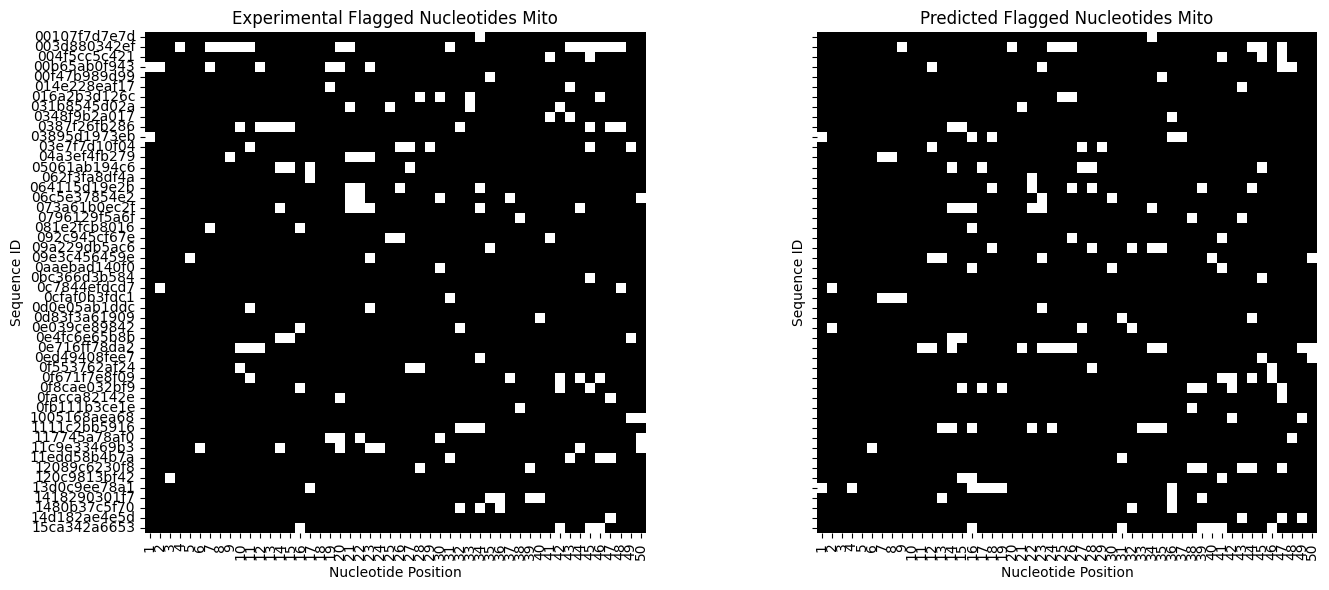

In [28]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Columns to process (excluding '_SN' columns)
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']
prediction_conditions = [col + '_pred_rdiff' for col in conditions]

# Create a new DataFrame to store flagged vectors
flagged_df = df[['id', 'sequence']].copy()

# Function to normalize the data using Min-Max Scaling
def normalize_data(reactivity_list):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(np.array(reactivity_list).reshape(-1, 1)).flatten()

# Function to flag nucleotides with a 20% cutoff on normalized data
def flag_nucleotides_normalized(reactivity_list, cutoff=0.2):
    return [1 if abs(val) > cutoff else 0 for val in reactivity_list]

# Process each condition and prediction condition
for col in conditions + prediction_conditions:
    flagged_df[col] = df[col].apply(lambda x: normalize_data(ast.literal_eval(str(x))))

# Visualization: Create a side-by-side grid for the first 10 sequences under "Mito" condition
n_sequences = 50  # Adjust as needed
condition = drug  # Drug condition of interest
prediction_condition = f"{drug}_pred_rdiff"  # Prediction condition of interest

# Filter the first 'n_sequences' sequences
sequences = flagged_df.iloc[:n_sequences]

# Extract the normalized experimental and predicted reactivity data
experimental_normalized = np.array(sequences[condition].apply(lambda x: normalize_data(x)).tolist())
predicted_normalized = np.array(sequences[prediction_condition].apply(lambda x: normalize_data(x)).tolist())

# Apply the 20% cutoff to flag nucleotides
experimental_flags = np.array([flag_nucleotides_normalized(seq, cutoff=0.80) for seq in experimental_normalized])
predicted_flags = np.array([flag_nucleotides_normalized(seq, cutoff=0.8) for seq in predicted_normalized])

# Create a plot with 2 side-by-side grids
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot experimental flagged nucleotides (on the left)
sns.heatmap(experimental_flags, cmap='gray', cbar=False, ax=axes[0],
            xticklabels=np.arange(1, experimental_flags.shape[1] + 1),  # Nucleotide positions
            yticklabels=sequences['id'], cbar_kws={'label': 'Flagged Nucleotides (Experimental)'},
            square=True, annot=False)
axes[0].set_title(f"Experimental Flagged Nucleotides {drug}")

# Plot predicted flagged nucleotides (on the right)
sns.heatmap(predicted_flags, cmap='gray', cbar=False, ax=axes[1],
            xticklabels=np.arange(1, predicted_flags.shape[1] + 1),  # Nucleotide positions
            yticklabels=sequences['id'], cbar_kws={'label': 'Flagged Nucleotides (Predicted)'},
            square=True, annot=False)
axes[1].set_title(f"Predicted Flagged Nucleotides {drug}")

# Labels and Titles
for ax in axes:
    ax.set_xlabel('Nucleotide Position')
    ax.set_ylabel('Sequence ID')

# Adjust layout
plt.tight_layout()
plt.show()

### RibonanzaNet-SM_005

Notes: Trained on all reactivity differences, *and* the absolute NoDr reactivity simultaneously.

* Job ID: 56196343
* From training on 2094 sequences, split training data into training and validation data.
* criterion: MAE
* epochs: 20
* train_snr_cutoff: 1
* val_snr_cutoff: 1
* training_script: SM_train_model_sim.py
* training data: rdiff_with_NoDr_abs_train.json
* validation data: rdiff_with_NoDr_abs_val.json
* test data: rdiff_with_NoDr_abs_test.json
* model saved as: RibonanzaNet-SM_005.pt
* sbatch script: sm_train_all_reac_diff_with_NoDr_abs.sbatch.sh
* Sherlock Job #: **56196343**



In [29]:
df = pd.read_json('RibonanzaNet-SM_005_test_data_with_preds.json')
df.columns

Index(['id', 'sequence', 'Argi', 'Eryt', 'Kana', 'Mito', 'NoDr', 'Paro',
       'Spec', 'Tetr', 'Argi_SN', 'Eryt_SN', 'Kana_SN', 'Mito_SN', 'NoDr_SN',
       'Paro_SN', 'Spec_SN', 'Tetr_SN', 'Argi_pred', 'Eryt_pred', 'Kana_pred',
       'Mito_pred', 'Paro_pred', 'Spec_pred', 'Tetr_pred', 'NoDr_pred'],
      dtype='object')

### Computing PCC with experimental and predicted reactivity vectors, per condition: 

In [30]:
import ast
import numpy as np
import pandas as pd

# Define condition columns
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']
prediction_conditions = [col + '_pred_rdiff' for col in conditions]

# Create a new DataFrame to hold results
comparison_results = {}

for col in conditions:
    pcc_list = []
    for exp_raw, pred_raw in zip(df[col], df[col + '_pred']):
        try:
            exp_vals = np.array(ast.literal_eval(str(exp_raw)))
            pred_vals = np.array(ast.literal_eval(str(pred_raw)))

            if len(exp_vals) == len(pred_vals) and len(exp_vals) > 1:
                pcc = np.corrcoef(exp_vals, pred_vals)[0, 1]
            else:
                pcc = None
        except Exception:
            pcc = None

        pcc_list.append(pcc)

    comparison_results[col] = pcc_list

# Create DataFrame with PCCs
comparison_df = pd.DataFrame(comparison_results)

# Display all individual PCCs
print(comparison_df)

# Compute average PCC per condition
average_pcc = comparison_df.mean()
print("\nAverage PCC per condition:")
print(average_pcc)


         Argi      Eryt      Kana      Mito      Paro      Spec      Tetr
0   -0.073349  0.146613  0.522655  0.664338  0.478878  0.093710  0.718207
1    0.239916  0.144259  0.104035  0.754670  0.656471  0.023940  0.599522
2    0.491596  0.512947  0.548066  0.944780  0.420625  0.468267  0.860166
3    0.131614  0.228405  0.532172  0.784789  0.731730  0.269133  0.702325
4    0.106142  0.546695  0.464161  0.899309  0.844514  0.349883  0.879721
..        ...       ...       ...       ...       ...       ...       ...
541  0.312875  0.402940  0.325424  0.216704  0.369490  0.297836  0.625674
542  0.246442  0.059837  0.452083  0.757632  0.616507  0.097206  0.511759
543 -0.175915  0.007064 -0.127808  0.902124  0.619283 -0.197315  0.830226
544 -0.339793 -0.091719 -0.080066  0.872281  0.410930 -0.242145  0.535478
545  0.290754  0.194675  0.246090  0.676904  0.586083  0.276398  0.712726

[546 rows x 7 columns]

Average PCC per condition:
Argi    0.151971
Eryt    0.200652
Kana    0.278094
Mito    0

### Computing PCC between a sliding window sum of nucleotides with significant reactivity differences: 

Significance is defined as beign in the top 20% of reactivity differences after normalization. 

In [35]:

# Columns to process (excluding '_SN' columns)
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']
prediction_conditions = [col + '_pred' for col in conditions]

# Create a new DataFrame to store flagged vectors
flagged_df = df[['id', 'sequence']].copy()

# Function to normalize and flag top 80%
def normalize_and_flag(reactivity_list):
    reactivity_array = np.array(reactivity_list)
    min_val, max_val = np.min(reactivity_array), np.max(reactivity_array)
    normalized = (reactivity_array - min_val) / (max_val - min_val) if max_val > min_val else reactivity_array
    threshold = np.percentile(normalized, 80)
    return [1 if val >= threshold else 0 for val in normalized]

# Function to compute sliding window sums
def sliding_window_sum(flagged_list, window_size=1):
    return [sum(flagged_list[i:i+window_size]) for i in range(len(flagged_list) - window_size + 1)]

# Process each condition and prediction condition
for col in conditions + prediction_conditions:
    flagged_df[col] = df[col].apply(lambda x: normalize_and_flag(ast.literal_eval(str(x))))

# Compute sliding window sums
for col in conditions + prediction_conditions:
    flagged_df[col + '_window_sum'] = flagged_df[col].apply(lambda x: sliding_window_sum(x))

# Compare actual to predicted
comparison_results = {}
for col in conditions:
    actual_sums = flagged_df[col + '_window_sum']
    predicted_sums = flagged_df[col + '_pred_window_sum']
    comparison_results[col] = [np.corrcoef(actual, predicted)[0, 1] if len(actual) == len(predicted) else None
                               for actual, predicted in zip(actual_sums, predicted_sums)]

comparison_df = pd.DataFrame(comparison_results)

#print(comparison_df)

# Compute average correlation coefficient for each column
average_correlation = comparison_df.mean()

# Display the results
print("Flagged Nucleotides Comparison DataFrame:")
print(comparison_df)
print("\nAverage Correlation Coefficients:")
print(average_correlation.to_frame(name="Average Correlation"))

Flagged Nucleotides Comparison DataFrame:
             Argi          Eryt   Kana      Mito      Paro          Spec  \
0    6.245005e-17  5.898060e-17  0.375  0.337963  0.375000  9.656091e-02   
1    2.500000e-01  7.632783e-17  0.125  0.125000  0.375000  3.122502e-17   
2    3.379632e-01  1.250000e-01  0.375  0.750000  0.250000  1.250000e-01   
3    1.387779e-17  2.500000e-01  0.250  0.500000  0.500000  1.250000e-01   
4    3.122502e-17  9.020562e-17  0.500  0.625000  0.625000  2.500000e-01   
..            ...           ...    ...       ...       ...           ...   
541  2.500000e-01  2.500000e-01  0.250  0.250000  0.250000  2.172620e-01   
542  2.500000e-01 -2.414023e-02  0.375  0.375000  0.337963  7.285839e-17   
543  1.250000e-01  1.250000e-01  0.125  0.625000  0.500000 -2.500000e-01   
544 -1.250000e-01  6.938894e-18  0.250  0.625000  0.125000 -1.250000e-01   
545  5.551115e-17  2.500000e-01  0.500  0.700067  0.625000  3.750000e-01   

         Tetr  
0    0.500000  
1    0.217262

## Showing the general trend that model performance is correlated with frequency of nucleotides that had significant reactivity differences

Different method to flag nucleotides here - nucleotides are flagged if the reactivity *difference* is greater than 0.3. 

In [37]:
import pandas as pd
import ast

# Columns to process (excluding '_SN' columns)
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']

# Function to flag nucleotides based on reactivity difference > 0.3
def flag_nucleotides(reactivity_list, threshold=0.3):
    return [1 if abs(val) > threshold else 0 for val in reactivity_list]

# Function to count sequences with more than 3 flagged nucleotides
def count_flagged_sequences(df, conditions):
    # Create a dictionary to store counts of flagged sequences per condition
    flagged_counts = {}

    for condition in conditions:
        # Initialize a count for sequences with > 3 flagged nucleotides
        flagged_count = 0

        # Process each sequence for the current condition
        for _, row in df.iterrows():
            reactivity_list = ast.literal_eval(str(row[condition]))  # Get the reactivity list
            flagged_nucleotides = flag_nucleotides(reactivity_list)  # Flag nucleotides
            if sum(flagged_nucleotides) > 3:  # Check if there are more than 3 flagged nucleotides
                flagged_count += 1

        # Store the count for the current condition
        flagged_counts[condition] = flagged_count

    return flagged_counts

# Assuming 'df' is your DataFrame
flagged_counts = count_flagged_sequences(df, conditions)

# Print the number of flagged sequences for each condition
for condition, count in flagged_counts.items():
    print(f"Condition: {condition}, Flagged Sequences > 3: {count}, {count/len(df)} %")


Condition: Argi, Flagged Sequences > 3: 59, 0.10805860805860806 %
Condition: Eryt, Flagged Sequences > 3: 75, 0.13736263736263737 %
Condition: Kana, Flagged Sequences > 3: 64, 0.11721611721611722 %
Condition: Mito, Flagged Sequences > 3: 526, 0.9633699633699634 %
Condition: Paro, Flagged Sequences > 3: 352, 0.6446886446886447 %
Condition: Spec, Flagged Sequences > 3: 68, 0.12454212454212454 %
Condition: Tetr, Flagged Sequences > 3: 269, 0.4926739926739927 %


In [38]:
drug = input('insert drug name: ')

insert drug name: Eryt


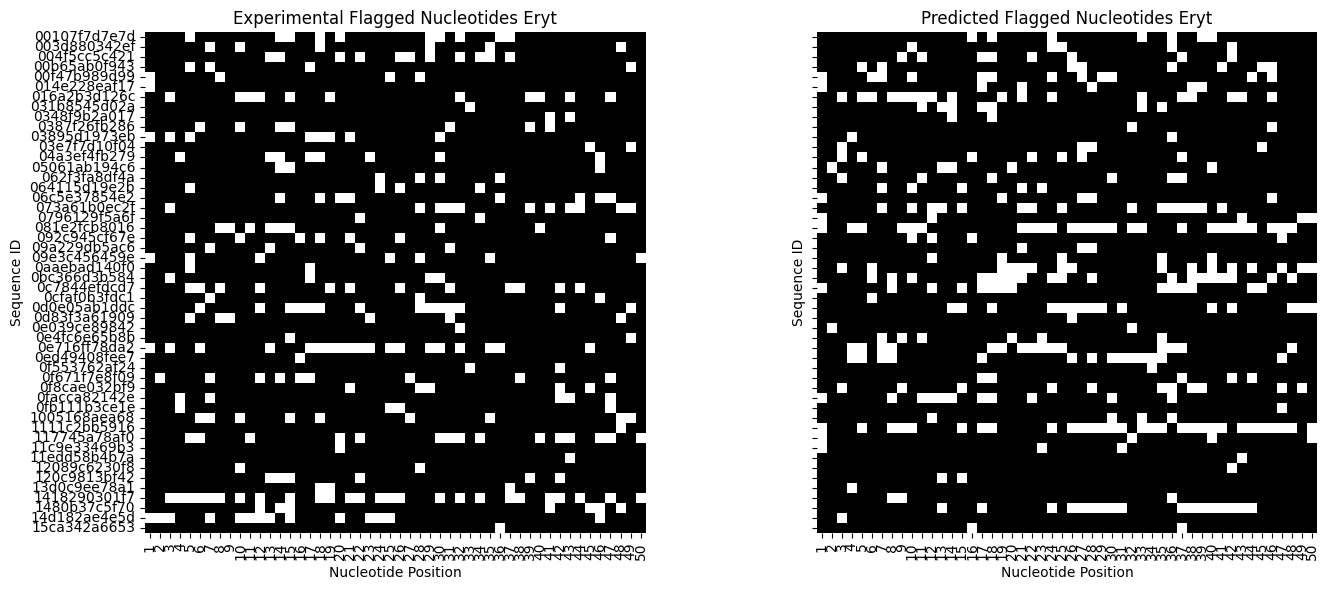

In [39]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Columns to process (excluding '_SN' columns)
conditions = ['Argi', 'Eryt', 'Kana', 'Mito', 'Paro', 'Spec', 'Tetr']
prediction_conditions = [col + '_pred' for col in conditions]

# Create a new DataFrame to store flagged vectors
flagged_df = df[['id', 'sequence']].copy()

# Function to normalize the data using Min-Max Scaling
def normalize_data(reactivity_list):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(np.array(reactivity_list).reshape(-1, 1)).flatten()

# Function to flag nucleotides with a 20% cutoff on normalized data
def flag_nucleotides_normalized(reactivity_list, cutoff=0.2):
    return [1 if abs(val) > cutoff else 0 for val in reactivity_list]

# Process each condition and prediction condition
for col in conditions + prediction_conditions:
    flagged_df[col] = df[col].apply(lambda x: normalize_data(ast.literal_eval(str(x))))

# Visualization: Create a side-by-side grid for the first 10 sequences under "Mito" condition
n_sequences = 50  # Adjust as needed
condition = drug  # Drug condition of interest
prediction_condition = f"{drug}_pred"  # Prediction condition of interest

# Filter the first 'n_sequences' sequences
sequences = flagged_df.iloc[:n_sequences]

# Extract the normalized experimental and predicted reactivity data
experimental_normalized = np.array(sequences[condition].apply(lambda x: normalize_data(x)).tolist())
predicted_normalized = np.array(sequences[prediction_condition].apply(lambda x: normalize_data(x)).tolist())

# Apply the 20% cutoff to flag nucleotides
experimental_flags = np.array([flag_nucleotides_normalized(seq, cutoff=0.80) for seq in experimental_normalized])
predicted_flags = np.array([flag_nucleotides_normalized(seq, cutoff=0.8) for seq in predicted_normalized])

# Create a plot with 2 side-by-side grids
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot experimental flagged nucleotides (on the left)
sns.heatmap(experimental_flags, cmap='gray', cbar=False, ax=axes[0],
            xticklabels=np.arange(1, experimental_flags.shape[1] + 1),  # Nucleotide positions
            yticklabels=sequences['id'], cbar_kws={'label': 'Flagged Nucleotides (Experimental)'},
            square=True, annot=False)
axes[0].set_title(f"Experimental Flagged Nucleotides {drug}")

# Plot predicted flagged nucleotides (on the right)
sns.heatmap(predicted_flags, cmap='gray', cbar=False, ax=axes[1],
            xticklabels=np.arange(1, predicted_flags.shape[1] + 1),  # Nucleotide positions
            yticklabels=sequences['id'], cbar_kws={'label': 'Flagged Nucleotides (Predicted)'},
            square=True, annot=False)
axes[1].set_title(f"Predicted Flagged Nucleotides {drug}")

# Labels and Titles
for ax in axes:
    ax.set_xlabel('Nucleotide Position')
    ax.set_ylabel('Sequence ID')

# Adjust layout
plt.tight_layout()
plt.show()